In [1]:
import numpy as np
import pyuvdata
from newcal import (
    caldata,
    calibration_wrappers,
    calibration_optimization,
    cost_function_calculations,
)
import matplotlib.pyplot as plt
import importlib
importlib.reload(caldata)
importlib.reload(calibration_wrappers)
importlib.reload(calibration_optimization)
importlib.reload(cost_function_calculations)

<module 'newcal.cost_function_calculations' from '/usr/local/miniconda3/envs/py310/lib/python3.10/site-packages/newcal/cost_function_calculations.py'>

In [2]:
THIS_DIR = "/home/rbyrne/newcal/newcal"

In [3]:
test_freq_ind = 0
test_pol_ind = 0
delta_val = 1e-8
amplitude_perturbation = 1.3
use_Nfreqs = 3

In [4]:
# Get data
model = pyuvdata.UVData()
model.read(f"{THIS_DIR}/data/test_model_1freq.uvfits")
data = pyuvdata.UVData()
data.read(f"{THIS_DIR}/data/test_data_1freq.uvfits")

data_copy = data.copy()
model_copy = model.copy()
for ind in range(1, use_Nfreqs):
    data_copy.freq_array += 1e6
    model_copy.freq_array += 1e6 * ind
    data.fast_concat(data_copy, "freq", inplace=True)
    model.fast_concat(model_copy, "freq", inplace=True)

# Added for debugging
data.select(polarizations=[-5], blt_inds=[0, 1], inplace=True)
model.select(polarizations=[-5], blt_inds=[0, 1], inplace=True)

caldata_obj = caldata.CalData()
caldata_obj.load_data(data, model)

caldata_obj.visibility_weights[:, :, :, :] = 1  # Unflag all


Combined frequencies are separated by more than their channel width. This will make it impossible to write this data out to some file types.
Combined frequencies are separated by more than their channel width. This will make it impossible to write this data out to some file types.
Combined frequencies are separated by more than their channel width. This will make it impossible to write this data out to some file types.
Combined frequencies are not evenly spaced or have differing values of channel widths. This will make it impossible to write this data out to some file types.


In [5]:
caldata_obj.dwcal_inv_covariance = np.random.rand(
    caldata_obj.Ntimes,
    caldata_obj.Nbls,
    caldata_obj.Nfreqs,
    caldata_obj.Nfreqs,
    caldata_obj.N_vis_pols,
) + 1j * np.random.rand(
    caldata_obj.Ntimes,
    caldata_obj.Nbls,
    caldata_obj.Nfreqs,
    caldata_obj.Nfreqs,
    caldata_obj.N_vis_pols,
)
caldata_obj.dwcal_inv_covariance = np.transpose(
    np.matmul(
        np.transpose(caldata_obj.dwcal_inv_covariance, axes=(0, 1, 4, 2, 3)),
        np.conj(np.transpose(caldata_obj.dwcal_inv_covariance, axes=(0, 1, 4, 3, 2))),
    ),
    axes=(0, 1, 3, 4, 2),
)  # Enforce that the matrix is Hermitian

In [6]:
amp_terms_1 = np.copy(caldata_obj.abscal_params[0, :, test_pol_ind])
amp_terms_1[test_freq_ind] += delta_val / 2
print(amp_terms_1)
amp_terms_2 = np.copy(caldata_obj.abscal_params[0, :, test_pol_ind])
amp_terms_2[test_freq_ind] -= delta_val / 2
print(amp_terms_2)

cost1 = cost_function_calculations.cost_function_dw_abscal(
    amp_terms_1,
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)
cost0 = cost_function_calculations.cost_function_dw_abscal(
    amp_terms_2,
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)

amp_jac, phase_jac = cost_function_calculations.jacobian_dw_abscal(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)

grad_approx = (cost1 - cost0) / delta_val

print(f"Gradient approximation value: {grad_approx}")
print(f"Jacobian value: {amp_jac[test_freq_ind]}")

[1. 1. 1.]
[1. 1. 1.]
DWAbscal cost: 0.489336488018646
DWAbscal cost: 0.48933362403322817
Gradient approximation value: 286.3985417822512
Jacobian value: 286.3985441485788


In [7]:
for amp_val in [1-delta_val/2, 1+delta_val/2]:
    use_amps = np.array([amp_val, 1, 1])
    cost = cost_function_calculations.cost_function_dw_abscal(
        use_amps,
        caldata_obj.abscal_params[1:, :, test_pol_ind],
        caldata_obj.model_visibilities[:, :, :, test_pol_ind],
        caldata_obj.data_visibilities[:, :, :, test_pol_ind],
        caldata_obj.uv_array,
        caldata_obj.visibility_weights[:, :, :, test_pol_ind],
        caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
    )
    print(cost)

DWAbscal cost: 0.48933362403322817
0.48933362403322817
DWAbscal cost: 0.489336488018646
0.489336488018646


In [8]:
res_vec = (caldata_obj.data_visibilities-caldata_obj.model_visibilities).flatten()
print(res_vec)

[-0.00899124+0.17314911j -0.00899124+0.17314911j -0.00899124+0.17314911j]


In [9]:
cov_mat = caldata_obj.dwcal_inv_covariance[0,0,:,:,0]
print(cov_mat)

[[1.91052809+0.j         2.20687059+0.19913172j 1.23204346+0.95762575j]
 [2.20687059-0.19913172j 2.82649282+0.j         1.36532437+0.64353261j]
 [1.23204346-0.95762575j 1.36532437-0.64353261j 1.93232493+0.j        ]]


In [10]:
cost_estimated = np.einsum("i,ij,j", np.conj(res_vec), cov_mat, res_vec)
print(cost_estimated)

(0.4893350560248374-4.336808689942018e-19j)


In [11]:
cost = cost_function_calculations.cost_function_dw_abscal(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)
print(cost)

DWAbscal cost: 0.4893350560248374
0.4893350560248374


In [12]:
jac_estimated = (
    4
    * np.real(np.conj(caldata_obj.data_visibilities.flatten())
    * np.einsum("ij,j", cov_mat, res_vec)
))
print(jac_estimated)

[286.39854415 327.14156831 200.11138996]


In [13]:
jac_estimated = (
    2
    * np.conj(caldata_obj.data_visibilities.flatten())
    * np.einsum("ij,j", cov_mat, res_vec)
) + (
    2
    * caldata_obj.data_visibilities.flatten()
    * np.einsum("ij,j", np.conj(cov_mat), np.conj(res_vec))
)
print(jac_estimated)

[286.39854415+0.j 327.14156831+0.j 200.11138996+0.j]


In [14]:
jac = cost_function_calculations.jacobian_dw_abscal(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)
print(jac)

(array([286.39854415, 327.14156831, 200.11138996]), array([[ 818.17567573, 2256.11934627, 4202.74487446],
       [  65.76064372,  181.33496867,  337.79445728]]))


In [15]:
avg_spectra = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/mean_variance_abscal_nbins200_xx.npz"
)
delay_spectrum_variance = avg_spectra["variance"]
bl_length_bin_edges = avg_spectra["bl_bin_edges"]
delay_axis = avg_spectra["delay_array"]

data_path = "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
model_path = "/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.45004.sum.abs_calibrated.red_avg_model.uvfits"
data = pyuvdata.UVData()
data.read(data_path)
model = pyuvdata.UVData()
model.read(model_path)
data.select(frequencies=data.freq_array[0,0:200])
model.select(frequencies=model.freq_array[0, 0:200])

data.inflate_by_redundancy(use_grid_alg=True)
model.inflate_by_redundancy(use_grid_alg=True)

# Model does not include all baselines
model_baselines = list(set(list(zip(model.ant_1_array, model.ant_2_array))))
data_baselines = list(set(list(zip(data.ant_1_array, data.ant_2_array))))
use_baselines = [
    baseline
    for baseline in model_baselines
    if (baseline in data_baselines) or (baseline[::-1] in data_baselines)
]
use_polarizations = -5  # Use XX only
data.select(bls=use_baselines, polarizations=use_polarizations)
model.select(bls=use_baselines, polarizations=use_polarizations)

# Align phasing
data.phase_to_time(np.mean(data.time_array))
model.phase_to_time(np.mean(data.time_array))

data.compress_by_redundancy()
model.compress_by_redundancy()

Missing some redundant groups. Filling in available data.
Missing some redundant groups. Filling in available data.


In [16]:
initial_abscal_params = np.zeros((3, data.Nfreqs, 1))
initial_abscal_params[0, :, 0] = np.random.normal(1.0, scale=0.1, size=(data.Nfreqs))
initial_abscal_params[1, :, 0] = np.random.normal(0.0, scale=0.01, size=(data.Nfreqs))
initial_abscal_params[2, :, 0] = np.random.normal(0.0, scale=0.01, size=(data.Nfreqs))

In [17]:
# Run DWAbscal
dwabscal_params = calibration_wrappers.dw_absolute_calibration(
    data,
    data,
    #np.ones_like(delay_spectrum_variance),
    delay_spectrum_variance,
    bl_length_bin_edges,
    delay_axis,
    initial_abscal_params=initial_abscal_params,
    verbose=True,
    xtol=1e-6,
    maxiter=50,
)

print(dwabscal_params)

Reading data...
Formatting data...
Done. Data formatting time 0.0027654608090718585 minutes.
Calculating delay weighting matrix...


invalid value encountered in divide


Done. Time calculating delay weighting matrix 0.027025059858957926 minutes.
Running calibration optimization...
DWAbscal cost: 9215986179.231985
Initial cost: 9215986179.231985
DWAbscal cost: 9215986179.231985
DWAbscal cost: 19770979979.14371
DWAbscal cost: 14646865745.993216
DWAbscal cost: 3848540282.9437833
DWAbscal cost: 4478083632.346255
DWAbscal cost: 2121006521.0936375
DWAbscal cost: 1609266990.6676195
DWAbscal cost: 1178088768.9356613
DWAbscal cost: 855272869.2082646
DWAbscal cost: 824475157.7899617
DWAbscal cost: 648256260.6444273
DWAbscal cost: 579746194.4155306
DWAbscal cost: 451409192.9685495
DWAbscal cost: 236568132.09667337
DWAbscal cost: 34744076.605162516
DWAbscal cost: 33298955.67567699
DWAbscal cost: 30456722.742513973
DWAbscal cost: 20631186.379070044
DWAbscal cost: 5040890.95655801
DWAbscal cost: 4842150.392480528
DWAbscal cost: 4451689.211776696
DWAbscal cost: 3110304.2253384735
DWAbscal cost: 894081.9314721822
DWAbscal cost: 817389.7554865318
DWAbscal cost: 701791.

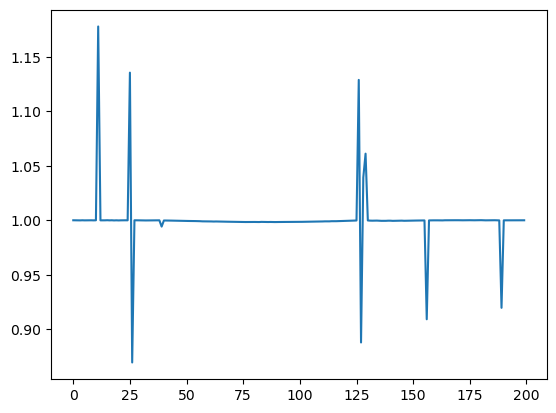

In [24]:
plt.plot(dwabscal_params[0, :, 0])

In [19]:
print(dwabscal_params[0, :, 0])

[1.00004127 0.99999613 1.00001352 0.99993916 1.00003142 0.99995021
 0.99999715 1.00002069 1.00002538 0.99995603 1.00002835 1.17811047
 0.99997428 0.99994718 0.99999292 1.00008159 0.99996634 1.00004723
 0.99989686 0.99999826 0.99989732 0.99998488 0.99995416 1.00002261
 0.99999968 1.13569522 0.86937341 1.00004052 1.00003643 1.00000783
 0.99994816 0.99987578 0.99987477 0.99988429 0.99992673 0.99995044
 0.99992238 1.00000892 1.00000061 0.99423357 0.99984011 0.99977691
 0.99976986 0.99974762 0.99971536 0.99963695 0.99958315 0.99956037
 0.99953287 0.99950166 0.99945948 0.99938965 0.99933362 0.99930741
 0.99930119 0.99927489 0.99918628 0.9990572  0.99904355 0.9990782
 0.9990577  0.99895999 0.99887636 0.9989384  0.99887567 0.99882197
 0.99880115 0.99876351 0.99871524 0.99867493 0.99863394 0.99858923
 0.99853068 0.99845641 0.99851774 0.99852061 0.99843511 0.99846757
 0.99851408 0.99846128 0.99848297 0.99843223 0.99841631 0.9985529
 0.99847932 0.99835464 0.99843431 0.99848433 0.99841097 0.998395

In [20]:
caldata_obj = caldata.CalData()
caldata_obj.load_data(
    data,
    data,
)
caldata_obj.abscal_params = initial_abscal_params
calibration_wrappers.get_dwcal_weights_from_delay_spectra(
    caldata_obj,
    delay_spectrum_variance,
    bl_length_bin_edges,
    delay_axis,
)

invalid value encountered in divide


In [21]:
def newtons_method_optimizer(
    x0,
    caldata_obj,
    step_size=0.1,
    covergence_condition=0.001,
    maxiters=100,
):

    n_iters = 0
    convergence_iters = 0
    while convergence_iters < 3 and n_iters <= maxiters:
        hess_mat = calibration_optimization.hessian_dw_abscal_wrapper(
            x0, list(range(caldata_obj.Nfreqs)), caldata_obj
        )
        hess_mat_inv = np.linalg.inv(hess_mat)
        del hess_mat
        jac = calibration_optimization.jacobian_dw_abscal_wrapper(
            x0,
            list(range(caldata_obj.Nfreqs)),
            caldata_obj,
        )
        x1 = x0 - step_size * np.matmul(hess_mat_inv, jac)
        del hess_mat_inv
        del jac
        cost = calibration_optimization.cost_dw_abscal_wrapper(
            x0,
            list(range(caldata_obj.Nfreqs)),
            caldata_obj,
        )
        print(f"Iteration {n_iters}, cost func value: {cost}")
        check_conv = np.max(np.abs(x1 - x0))
        if check_conv < covergence_condition:
            convergence_iters += 1
        else:
            convergence_iters = 0
        x0 = x1
        n_iters += 1

    return x1

In [22]:
x1 = newtons_method_optimizer(caldata_obj.abscal_params[:, :, 0].flatten(), caldata_obj)

LinAlgError: Singular matrix

In [ ]:
print(x1)

NameError: name 'x1' is not defined